<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C2/C2.html"><img src="../data/C2_nav.png" width="100"  style="float:right;" alt="C1"></a>
<h1> Discrete Fourier Transform (DFT)</h1> 
</div>

<br/>

<p>
In this notebook, we introduce the discrete Fourier transform (DFT) and its basic properties. We then study the fast Fourier transform (FFT), which is an efficient algorithm to evaluate the DFT. In most parts, we closely follow Section 2.4 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>.
</p> 

## Inner Product

An important concept for understanding the Fourier transform is the **inner product** for a complex vector space $\mathbb{C}^N$ for $N \in \mathbb{N}$. Given two complex vectors $x, y \in \mathbb{C}^N$, the inner product between $x$ and $y$ is defined as follows:

$$ \langle x | y \rangle := \sum_{n=0}^{N-1} x(n) \overline{y(n)}.$$

The absolute value of the inner product may be interpreted as a measure of similarity between $x$ and $y$: if $x$ and $y$ point to the same direction (i.e., $x$ and $y$ are similar), the inner product $|\langle x | y \rangle|$ is large. If $x$ and $y$ are orthogonal (i.e., $x$ and $y$ are dissimilar), the inner product $|\langle x | y \rangle|$ is zero.

Note that when using the function `np.vdot` to compute the inner product, the complex conjugate is performed on the first argument.  Therefore, for computing $\langle x | y \rangle$ as defined above, one has to call `np.vdot(y, x)`.

In [1]:
import numpy as np
from numba import jit

x = np.array([ 1.0, 1j, 1.0 + 1.0j ])
y = np.array([ 1.1, 1j, 0.9 + 1.1j ])
print('Vectors of high similarity:', np.abs(np.vdot(y, x)))

x = np.array([ 1.0,   1j, 1.0 + 1j ])
y = np.array([ 1.1, -1j, 0.1      ])
print('Vectors of low similarity:', np.abs(np.vdot(y, x)))

Vectors of high similarity: 4.104875150354758
Vectors of low similarity: 0.22360679774997913


## Definition of DFT

Let $x\in \mathbb{C}^N$ be a vector of length $N\in\mathbb{N}$. In the music signal context, $x$ can be interpreted as a discrete signal with samples $x(0), x(1), ..., x(N-1)$. Note that we start indexing with the index $0$. The **discrete Fourier transform** (DFT) of $x$ is defined by:

$$ X(k) := \sum_{n=0}^{N-1} x(n) \exp(-2 \pi i k n / N) $$

for $k \in [0:N-1]$. The vector $X\in\mathbb{C}^N$ can be interpreted as frequency representation of the time-domain signal $x$.   To obtain a geometric interpretation of the DFT, we define the vector $\mathbf{u}_k\in\mathbb{C}^N$ by

$$\mathbf{u}_k(n) :=  \exp(2 \pi i k n / N) = \cos(2 \pi k n / N) + i \sin(2 \pi k n / N)$$

for each $k \in [0:N-1]$. This vector can be regarded as a sampled version of the exponential function of frequency $k/N$. Then, the DFT can be expressed as inner products

$$ X(k) := \sum_{n=0}^{N-1} x(n) \overline{\mathbf{u}_k} = \langle x | \mathbf{u}_k \rangle$$

of the signal $x$ and the sampled exponential functions $\mathbf{u}_k$. The absolute value $|X(k)|$ indicates the degree of similarity between the signal $x$ and $\mathbf{u}_k$.

In the case that $x\in \mathbb{R}^N$ is a real-valued vector (which is always the case for our music signal scenario), we obtain:

$$ X(k) := \langle x |\mathrm{Re}(\mathbf{u}_k) \rangle - i\langle x | \mathrm{Im}(\mathbf{u}_k) \rangle $$

The following plot shows an example signal $x$ compared with functions $\overline{\mathbf{u}_k}$ for two different frequency parameters $k$. The real and imaginary part of $\overline{\mathbf{u}_k}$ are shown in <font color='red'> red</font> and <font color='blue'> blue</font>, respectively.

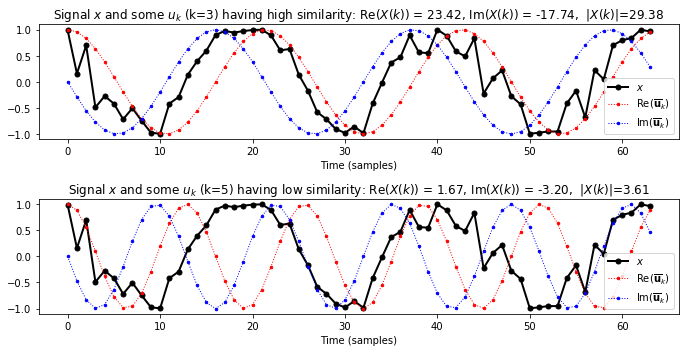

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

N = 64
n = np.arange(N)
k = 3
x = np.cos(2 * np.pi * (k * n / N) + (1.2*np.random.rand(N) - 0.0))

plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(n, x, 'k', marker='.', markersize='10', linewidth=2.0, label='$x$')
plt.xlabel('Time (samples)')
k = 3
u_k_real = np.cos(2 * np.pi * k * n / N)
u_k_imag = -np.sin(2 * np.pi * k * n / N)
u_k = u_k_real + u_k_imag*1j
sim_complex = np.vdot(u_k, x)
sim_abs = np.abs(sim_complex)
plt.title(r'Signal $x$ and some $u_k$ (k=3) having high similarity: Re($X(k)$) = %0.2f, Im($X(k)$) = %0.2f,  $|X(k)|$=%0.2f'%(sim_complex.real,sim_complex.imag,sim_abs))
plt.plot(n, u_k_real, 'r', marker='.', markersize='5', 
         linewidth=1.0, linestyle=':', label='$\mathrm{Re}(\overline{\mathbf{u}}_k)$');
plt.plot(n, u_k_imag, 'b', marker='.', markersize='5', 
         linewidth=1.0, linestyle=':', label='$\mathrm{Im}(\overline{\mathbf{u}}_k)$');
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(n, x, 'k', marker='.', markersize='10', linewidth=2.0, label='$x$')
plt.xlabel('Time (samples)')
k = 5
u_k_real = np.cos(2 * np.pi * k * n / N)
u_k_imag = -np.sin(2 * np.pi * k * n / N)
u_k = u_k_real + u_k_imag*1j
sim_complex = np.vdot(u_k, x)
sim_abs = np.abs(sim_complex)
plt.title(r'Signal $x$ and some $u_k$ (k=5) having low similarity: Re($X(k)$) = %0.2f, Im($X(k)$) = %0.2f,  $|X(k)|$=%0.2f'%(sim_complex.real,sim_complex.imag,sim_abs))
plt.plot(n, u_k_real, 'r', marker='.', markersize='5', 
         linewidth=1.0, linestyle=':', label='$\mathrm{Re}(\overline{\mathbf{u}}_k)$');
plt.plot(n, u_k_imag, 'b', marker='.', markersize='5', 
         linewidth=1.0, linestyle=':', label='$\mathrm{Im}(\overline{\mathbf{u}}_k)$');
plt.legend()

plt.tight_layout()

## DFT Matrix

Being a linear operator $\mathbb{C}^N \to \mathbb{C}^N$, the DFT can be expressed by some $N\times N$-matrix. This leads to the famous DFT matrix $\mathrm{DFT}_N \in \mathbb{C}^{N\times N}$ matrix, which is given by

$$\mathrm{DFT}_N(n, k) = \mathrm{exp}(-2 \pi i k n / N)$$

for $n\in[0:N-1]$ and $k\in[0:N-1]$. Let $\rho_N:=\exp(2 \pi i / N)$ be the primitive $N^\mathrm{th}$ root of unity as defined in the <a href="../C2/C2_ExponentialFunction.html">FMP notebook of the exponential function</a>. Then 

$$\sigma_N:= \overline{\rho_N} = \mathrm{exp}(-2 \pi i / N)$$

also defines a primitive $N^\mathrm{th}$ root of unity. From the properties of exponential functions, one obtains that

$$ \sigma_N^{kn} = \mathrm{exp}(-2 \pi i / N)^{kn} = \mathrm{exp}(-2 \pi i k n / N)$$

From this, one obtains:

$$
\mathrm{DFT}_N =
\begin{pmatrix}
    1 & 1 & 1 & \dots  & 1 \\
    1 & \sigma_N & \sigma_N^2 & \dots  & \sigma_N^{N-1} \\
    1 & \sigma_N^2 & \sigma_N^4 & \dots  & \sigma_N^{2(N-1)} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & \sigma_N^{N-1} & \sigma_N^{2(N-1)} & \dots  & \sigma_N^{(N-1)(N-1)} \\
\end{pmatrix}
$$

In the following visualization, the real and imaginary part of $\mathrm{DFT}_N$ are shown, where the values are encoded by suitable colors. Note that the $k^\mathrm{th}$ row of $\mathrm{DFT}_N$ corresponds to the vector $\mathbf{u}_k$ as defined above.

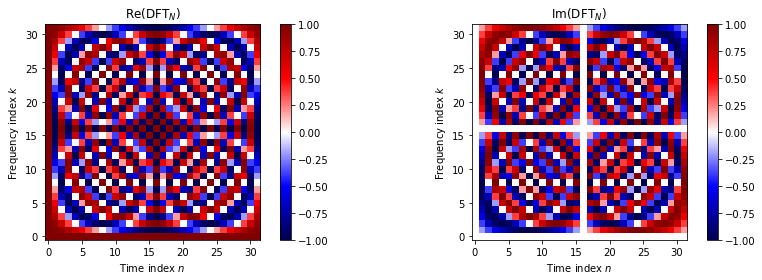

In [3]:
@jit(nopython=True)
def generate_matrix_dft(N, K):
    """Generates a DFT (discrete Fourier transfrom) matrix

    Notebook: C2/C2_DFT-FFT.ipynb

    Args:
        N (int): Number of samples
        K (int): Number of frequency bins

    Returns:
        dft (np.ndarray): The DFT matrix
    """
    dft = np.zeros((K, N), dtype=np.complex128)
    for n in range(N):
        for k in range(K):
            dft[k, n] = np.exp(-2j * np.pi * k * n / N)
    return dft

N = 32
dft_mat = generate_matrix_dft(N, N)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('$\mathrm{Re}(\mathrm{DFT}_N)$')
plt.imshow(np.real(dft_mat), origin='lower', cmap='seismic', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('$\mathrm{Im}(\mathrm{DFT}_N)$')
plt.imshow(np.imag(dft_mat), origin='lower', cmap='seismic', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()
plt.tight_layout()

We now write a function that computes the discrete Fourier transform $X = \mathrm{DFT}_N \cdot x$:

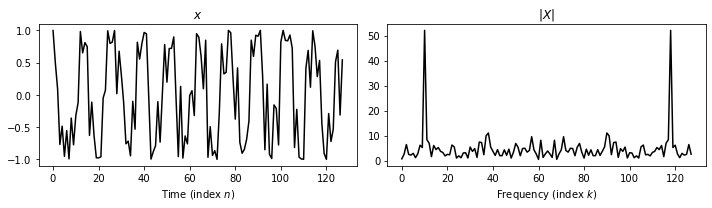

In [4]:
@jit(nopython=True)
def dft(x):
    """Compute the disrcete Fourier transfrom (DFT)

    Notebook: C2/C2_DFT-FFT.ipynb

    Args:
        x (np.ndarray): Signal to be transformed

    Returns:
        X (np.ndarray): Fourier transform of x
    """
    x = x.astype(np.complex128)
    N = len(x)
    dft_mat = generate_matrix_dft(N, N)
    return np.dot(dft_mat, x)


N = 128
n = np.arange(N)
k = 10
x = np.cos(2 * np.pi * (k * n / N) + 2 * (np.random.rand(N) - 0.5)) 
X = dft(x)

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.title('$x$')
plt.plot(x, 'k')
plt.xlabel('Time (index $n$)')

plt.subplot(1, 2, 2)
plt.title('$|X|$')
plt.plot(np.abs(X), 'k')
plt.xlabel('Frequency (index $k$)')
plt.tight_layout()

## Fast Fourier Transform (FFT)

Next, we discuss the famous fast Fourier transform (FFT), which is a fast algorithm to compute the DFT. The FFT algorithm was originally found by Gauss in about 1805 and  then rediscovered by Cooley and Tukey in 1965. The FFT algorithm is based on the observation that applying a DFT of even size $N=2M$ can be expressed in terms of  applying two DFTs of half the size $M$. It exploits the fact that there are algebraic relations between the entries $\sigma_N^{kn} = \mathrm{exp}(-2 \pi i / N)^{kn}$ of DFT matrices. In particular, one has 

$$\sigma_M = \sigma_N^2$$

In the FFT algorithm, one computes the DFT of the even-indexed and the uneven-indexed entries of $x$:

\begin{align}
(A(0), \dots, A(N/2-1)) &= \mathrm{DFT}_{N/2} \cdot (x(0), x(2), x(4), \dots, x(N-2))\\
(B(0), \dots, B(N/2-1)) &= \mathrm{DFT}_{N/2} \cdot (x(1), x(3), x(5), \dots, x(N-1))
\end{align}

With these two DFTs of size $N/2$, one can compute the full DFT of size $N$ via:

\begin{eqnarray}
C(k) &=& \sigma_N^k \cdot B(k)\\
X(k) &=& A(k) + C(k)\\
X(N/2 + k) &=& A(k) - C(k)\\
\end{eqnarray}

for $k \in [0: N/2 - 1]$. The numbers $\sigma_N^k$ are also called *twiddle factors*. If $N$ is a power of two, this idea can be applied recursively until one reaches the computation of $\mathrm{DFT}_{1}$ (the case $N=1$), which is simply multiplication by one (i.e. just returning the signal of length $N=1$). For further details, we refer to Section 2.4.3 of <a href="http://www.music-processing.de">[Müller, FMP, Springer 2015])</a> (see also Table 2.1).

In the following code, there is a function `twiddle` that computes twiddle factors and a function `fft` that implements the FFT algorithm.

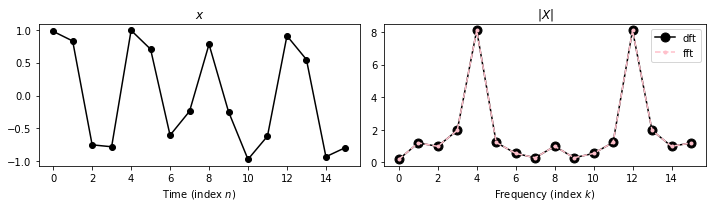

In [5]:
@jit(nopython=True)
def twiddle(N):
    """Generate the twiddle factors used in the computation of the fast Fourier transform (FFT)

    Notebook: C2/C2_DFT-FFT.ipynb

    Args:
        N (int): Number of samples

    Returns:
        sigma (np.ndarray): The twiddle factors
    """
    k = np.arange(N // 2)
    sigma = np.exp(-2j * np.pi * k / N)
    return sigma

@jit(nopython=True)
def fft(x):
    """Compute the fast Fourier transform (FFT)

    Notebook: C2/C2_DFT-FFT.ipynb

    Args:
        x (np.ndarray): Signal to be transformed

    Returns:
        X (np.ndarray): Fourier transform of x
    """
    x = x.astype(np.complex128)
    N = len(x)
    log2N = np.log2(N)
    assert log2N == int(log2N), 'N must be a power of two!'
    X = np.zeros(N, dtype=np.complex128)

    if N == 1:
        return x
    else:
        this_range = np.arange(N)
        A = fft(x[this_range % 2 == 0])
        B = fft(x[this_range % 2 == 1])
        C = twiddle(N) * B
        X[:N//2] = A + C
        X[N//2:] = A - C
        return X

N = 16
n = np.arange(N)
k = 4
x = np.cos(2 * np.pi * (k * n / N) + 2 * (np.random.rand(N) - 0.5)) 
X_via_dft = dft(x)
X_via_fft = fft(x)


plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.title('$x$')
plt.plot(x, 'k', marker='.', markersize=12)
plt.xlabel('Time (index $n$)')

plt.subplot(1, 2, 2)
plt.title('$|X|$')
plt.plot(np.abs(X_via_dft), 'k', marker='.', markersize=18, label='dft')
plt.plot(np.abs(X_via_fft), linestyle='--', color='pink', marker='.', markersize=6, label='fft')
plt.xlabel('Frequency (index $k$)')
plt.legend()

plt.tight_layout()

## Computational Complexity

The FFT reduces the overall number of operations from the order of $N^2$ (needed when computing the usual matrix&ndash;vector product $\mathrm{DFT}_N \cdot x$) to the order of $N\log_2N$. The savings are enormous. For example, using $N=2^{10}=1024$, the FFT requires roughly $N\log_2N=10240$ instead of $N^2=1048576$ operations in the naive approach.

Using the module `timeit`, which provides a simple way to time small bits of Python code, the following code compares the running time when using the naive approach and the FFT:

In [6]:
N = 512
n = np.arange(N)
x = np.sin(2 * np.pi * 5 * n / N )

print('Timing for DFT: ', end='')
%timeit dft(x)
print('Timing for FFT: ', end='')
%timeit fft(x)

Timing for DFT: 5.57 ms ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Timing for FFT: 768 µs ± 31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Let us now compare the running times by successively increasing the size $N$ (this may take a couple of seconds):

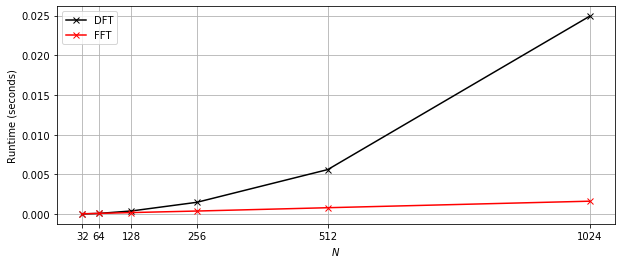

In [7]:
import timeit

Ns = [2 ** n for n in range(5, 11)]
times_dft = []
times_fft = []
execuctions = 5

for N in Ns:
    n = np.arange(N)
    x = np.sin(2 * np.pi * 5 * n / N )
    
    time_dft = timeit.timeit(lambda: dft(x), number=execuctions) / execuctions
    time_fft = timeit.timeit(lambda: fft(x), number=execuctions) / execuctions
    times_dft.append(time_dft)
    times_fft.append(time_fft)
    
plt.figure(figsize=(10, 4))
    
plt.plot(Ns, times_dft, '-xk', label='DFT')
plt.plot(Ns, times_fft, '-xr', label='FFT')
plt.xticks(Ns)
plt.legend()
plt.grid()
plt.xlabel('$N$')
plt.ylabel('Runtime (seconds)');

## Further Notes

The `dft` and `fft` functions have been included into `libfmp`. In the following code cell, we call those `libfmp` functions and time them again using the module `timeit`.

Timing for DFT: 6.67 ms ± 543 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Timing for FFT: 765 µs ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


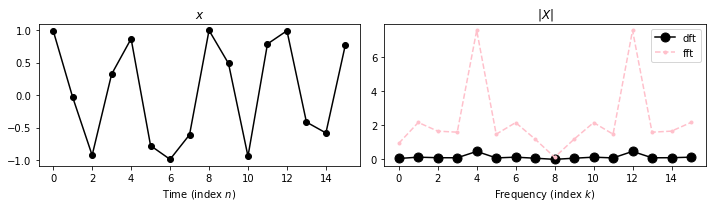

In [8]:
import sys
sys.path.append('..')
import libfmp.c2

N = 16
n = np.arange(N)
k = 4
x = np.cos(2 * np.pi * (k * n / N) + 2 * (np.random.rand(N) - 0.5)) 
X_via_dft = libfmp.c2.dft(x)
X_via_fft = libfmp.c2.fft(x)

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.title('$x$')
plt.plot(x, 'k', marker='.', markersize=12)
plt.xlabel('Time (index $n$)')

plt.subplot(1, 2, 2)
plt.title('$|X|$')
plt.plot(np.abs(X_via_dft), 'k', marker='.', markersize=18, label='dft')
plt.plot(np.abs(X_via_fft), linestyle='--', color='pink', marker='.', markersize=6, label='fft')
plt.xlabel('Frequency (index $k$)')
plt.legend()

plt.tight_layout()


N = 512
n = np.arange(N)
x = np.sin(2 * np.pi * 5 * n / N )

print('Timing for DFT: ', end='')
%timeit libfmp.c2.dft(x)
print('Timing for FFT: ', end='')
%timeit libfmp.c2.fft(x)

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a> and <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div>  

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>